In [1]:
import os, sys
import time
import copy
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import cv2

sys.path.append('..')

In [2]:
list_models = torchvision.models.list_models()

list_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, device):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

In [5]:
from src.capture import LazyCapture

def random_load(path): # 'path' can be either a '.avi' or a wildcard for '.jpeg' images
    length, W, H, C = None, None, None, None
    cap = cv2.VideoCapture(path)
    ret, _ = cap.read()
    if not ret:
        cap.release()
        raise Exception("Couldn't read video file: " + path)
    else:
        length, W, H, C = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), 3
    cap.release()
    perm = list(np.random.permutation(np.arange(length)))
    def frames(reverse=False):
        def _ahead():
            cap = cv2.VideoCapture(path)
            for i in perm:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                _, frame = cap.read()
                yield i, frame
            cap.release()
        def _reverse():
            cap = cv2.VideoCapture(path)
            for i in reversed(perm):
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                _, frame = cap.read()
                yield i, frame
            cap.release()
        return _reverse() if reverse else _ahead()
    return LazyCapture(length, W, H, C, frames)

In [6]:
def capture_size(cap, dtype=np.int32):
    return np.array([cap.W(), cap.H()], dtype=dtype)

In [7]:
import itertools as it
class FramesDataset(torch.utils.data.IterableDataset):
    def __init__(self, capture, labels, length=None):
        self.capture = capture
        self.labels = labels
        self.length = length

    def __iter__(self):
        def frames():
            count = 0
            for i, frame in self.capture.frames():
                if self.length is not None and count >= self.length:
                    break
                if i in self.labels:
                    frame = torch.from_numpy(np.transpose(frame, axes=(2, 0, 1)).astype(np.float32))
                    label = torch.Tensor(self.labels[i])
                    yield frame, label
                    count = count + 1
        return iter(frames())

    def __len__(self):
        return len(self.labels) if self.length is not None else self.length

In [8]:
from src.labels import load_labels, l2arr, larr2i

In [9]:
cap2 = random_load('../data/pw1_A1_0315_part2.avi')
lab2 = load_labels('../data/pw1_A1_0315_part2.txt')

cap3 = random_load('../data/pw1_A1_0315_part3.avi')
lab3 = load_labels('../data/pw1_A1_0315_part3.txt')

In [10]:
from src.cleaning import remove_outside_petri, remove_borders

In [11]:
cap2.apply(remove_outside_petri((cap2.W() // 2, cap2.H() // 2), ((cap2.W() // 2) - 10, (cap2.H() // 2) - 20)))
cap2.apply(remove_borders(10, hard=True), shape=(cap2.W() - 20, cap2.H() - 20, 3))
lab2 = {k: (l2arr(v) - 10.0) / capture_size(cap2, np.float32) for k, v in lab2.items()}

cap3.apply(remove_outside_petri((cap3.W() // 2, cap3.H() // 2), ((cap3.W() // 2) - 10, (cap3.H() // 2) - 20)))
cap3.apply(remove_borders(10, hard=True), shape=(cap3.W() - 20, cap3.H() - 20, 3))
lab3 = {k: (l2arr(v) - 10.0) / capture_size(cap3, np.float32) for k, v in lab3.items()}

In [12]:
from src.debug import print_frame

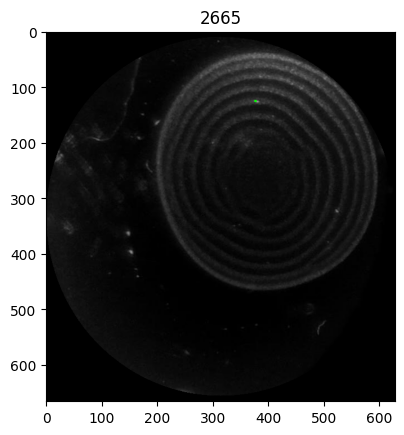

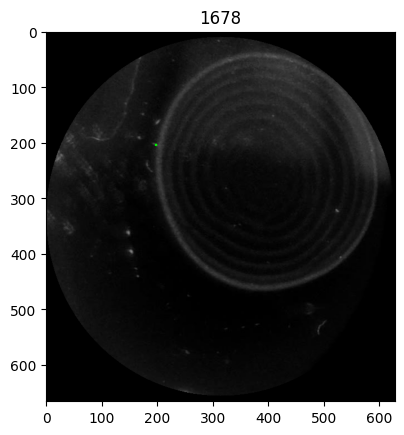

In [13]:
# Test
i2 = cap2.frame(0, index=False)
print_frame()(i2[0], i2[1], (larr2i(lab2[i2[0]] * capture_size(cap2, np.float32)), None))
i3 = cap3.frame(0, index=False)
print_frame()(i3[0], i3[1], (larr2i(lab3[i3[0]] * capture_size(cap3, np.float32)), None))

### Transfer learning

In [14]:
def requires_grad_false(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

In [15]:
train_loader = torch.utils.data.DataLoader(FramesDataset(cap3, lab3, length=400), batch_size=4)
val_loader = torch.utils.data.DataLoader(FramesDataset(cap3, lab3, length=100), batch_size=4)

#### Test1

In [16]:
model = torchvision.models.vgg19(pretrained=True)
model = requires_grad_false(model)

n_feat = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([torch.nn.Linear(n_feat, 2)])
model.classifier = torch.nn.Sequential(*features)

model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

/home/gbm/miniconda3/envs/ML-DL/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gbm/miniconda3/envs/ML-DL/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
model = train_model(model, {"train": train_loader, "val": val_loader}, criterion, optimizer, 2, device)

Epoch 0/1
----------
train Loss: 0.0125
val Loss: 0.0016

Epoch 1/1
----------
train Loss: 0.0120
val Loss: 0.0011

Training complete in 7m 54s


[205 198] [415 269]


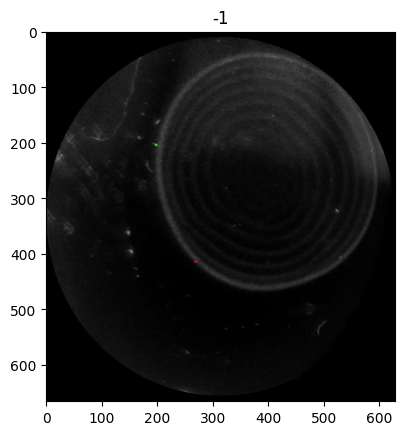

[388 254] [487 366]


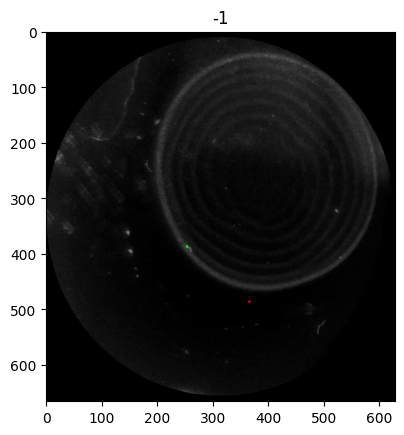

[219 227] [480 327]


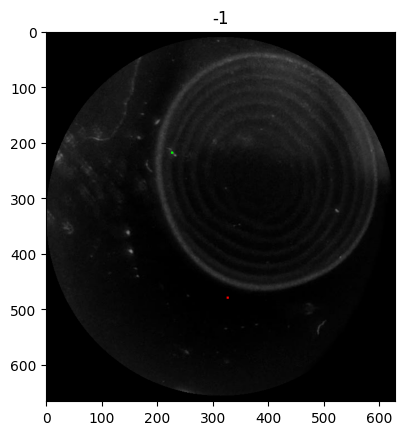

[292 207] [716 526]


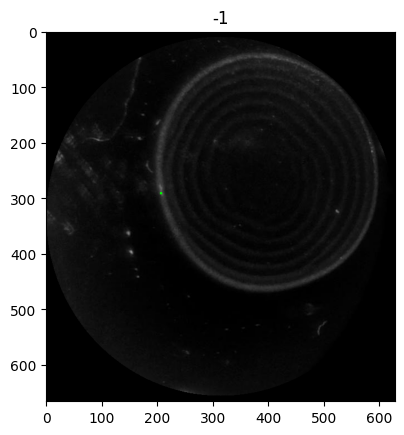

[203 204] [437 318]


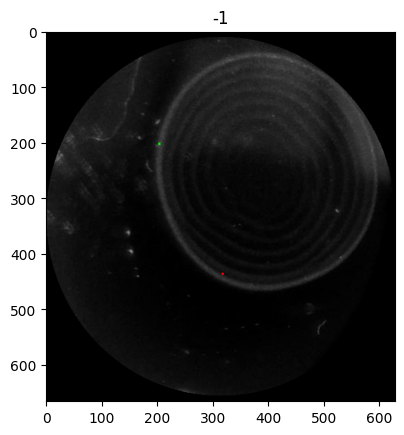

[371 239] [732 493]


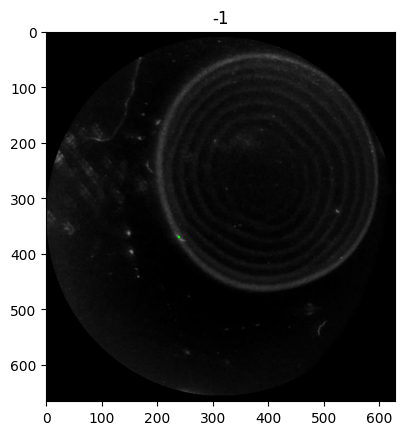

[386 243] [698 500]


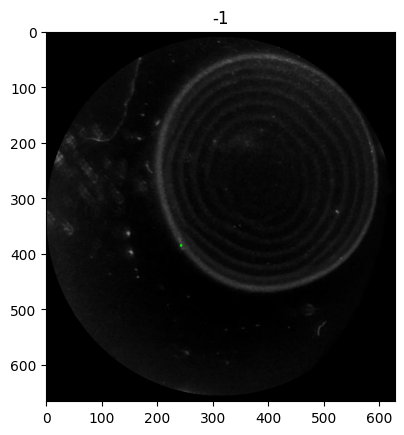

[275 205] [514 387]


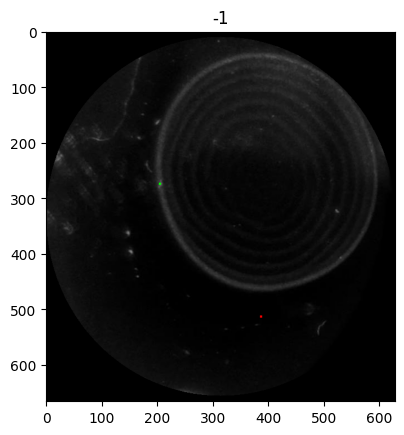

[387 247] [706 485]


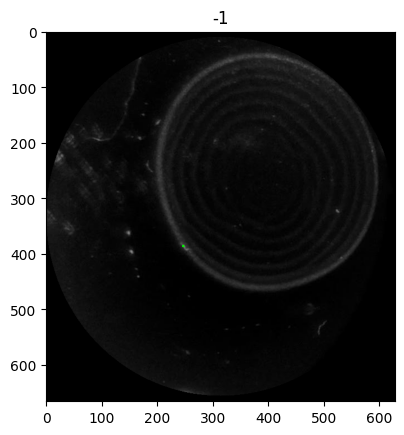

[131 228] [421 341]


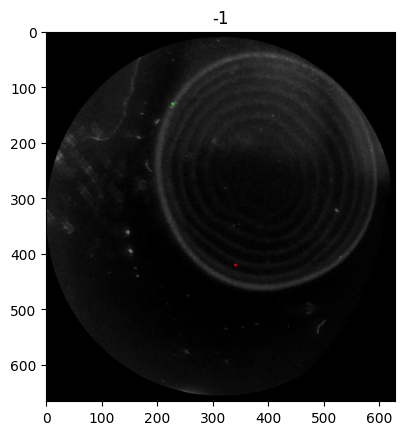

[175 210] [461 353]


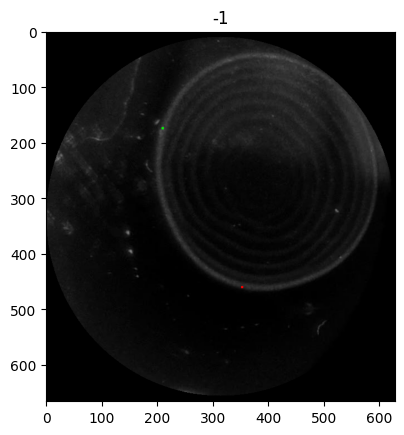

[376 243] [671 484]


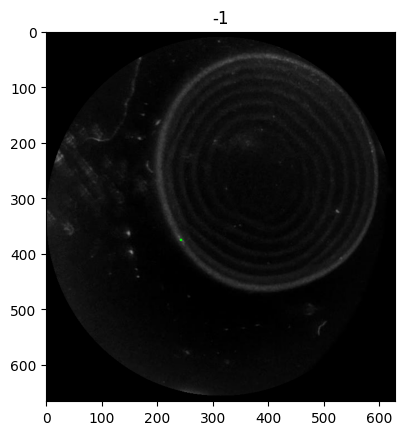

[212 212] [390 297]


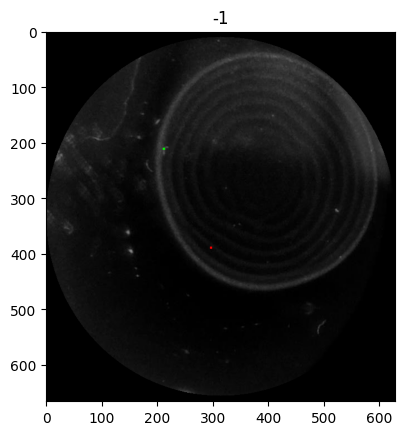

[462 411] [535 390]


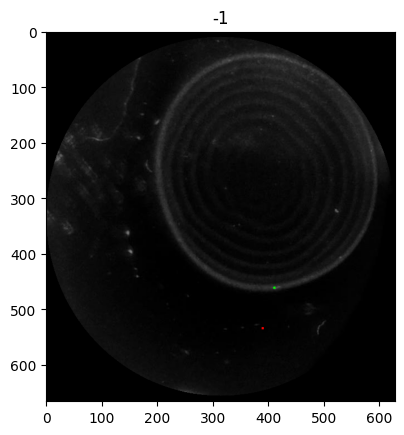

[404 267] [718 522]


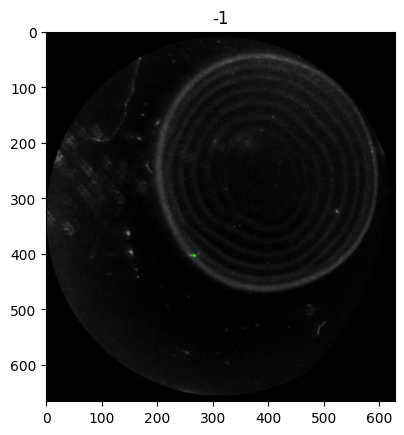

[266 217] [487 376]


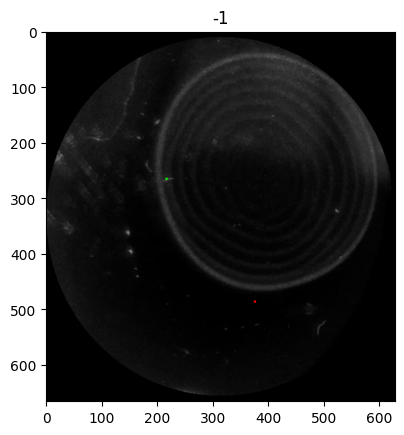

[272 207] [468 362]


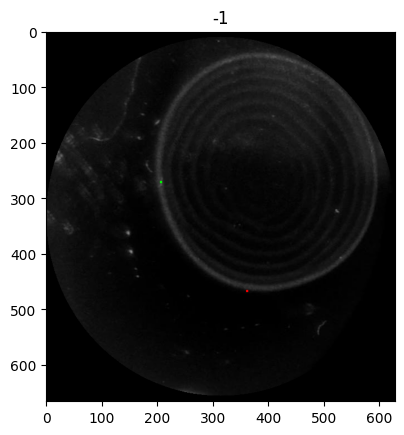

[271 205] [468 420]


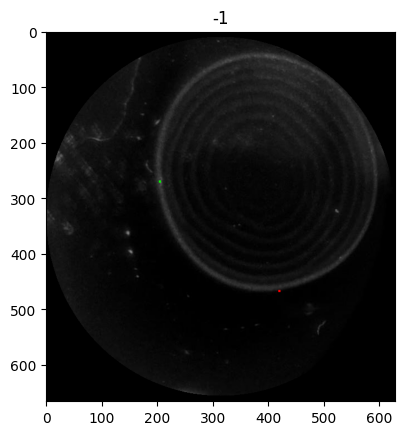

[303 215] [463 327]


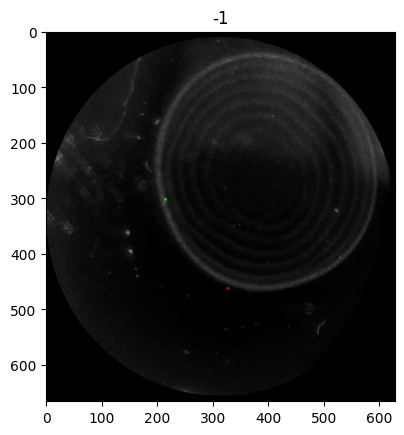

[335 221] [690 519]


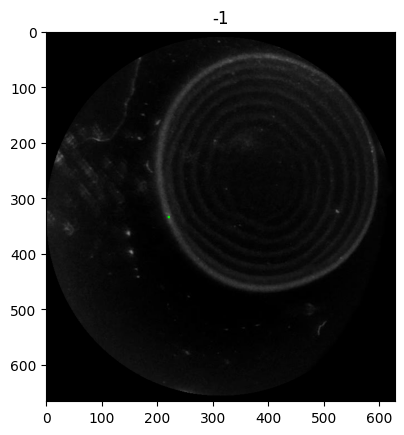

[452 330] [550 425]


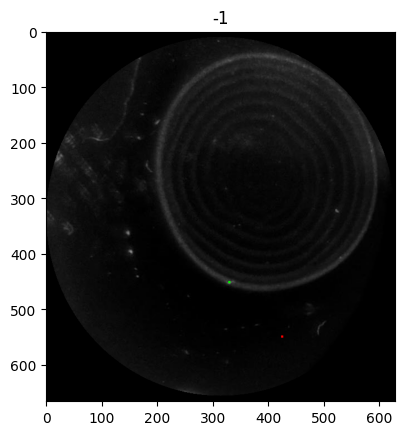

[271 205] [479 394]


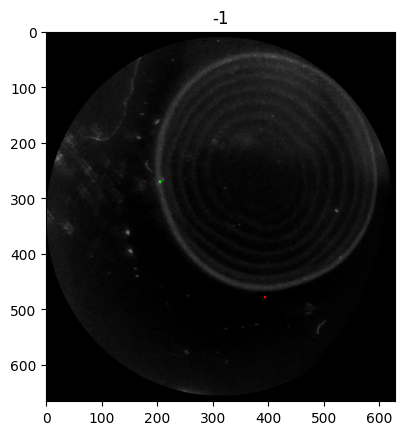

[455 346] [550 437]


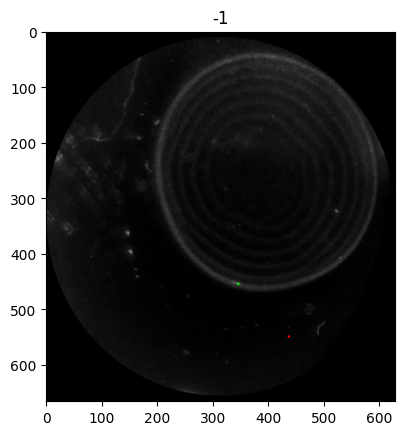

[405 262] [684 448]


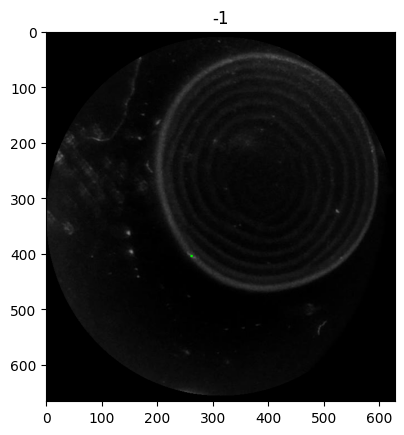

[242 199] [463 306]


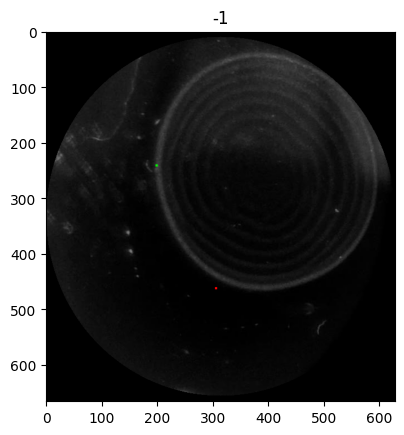

[374 241] [660 499]


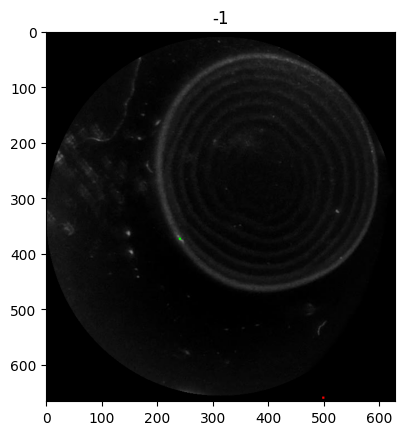

[461 418] [520 407]


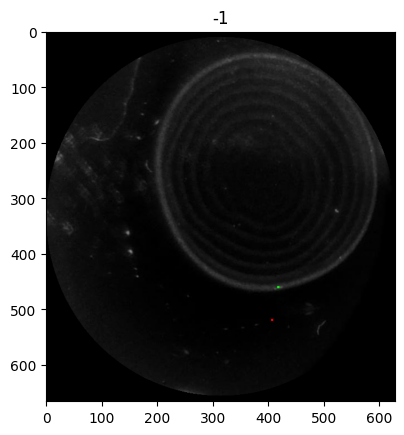

[336 219] [477 420]


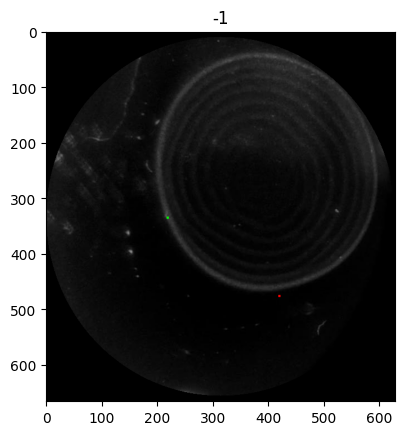

[375 242] [694 494]


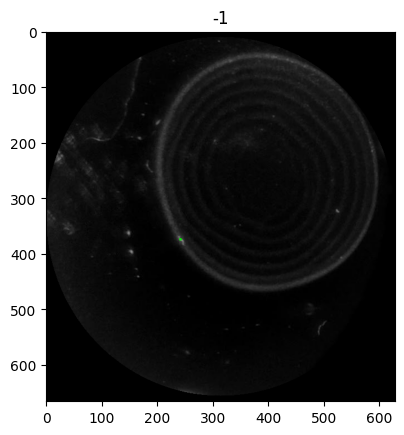

[420 281] [595 435]


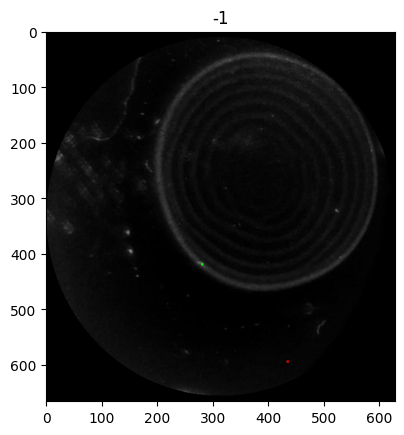

[406 264] [654 474]


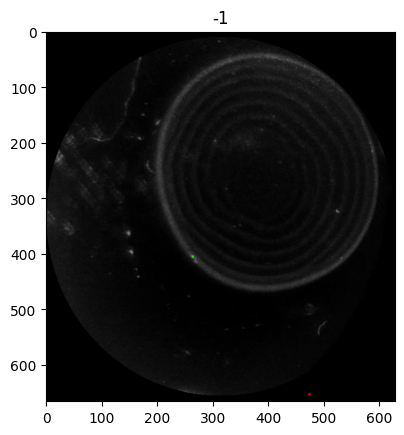

[440 312] [527 404]


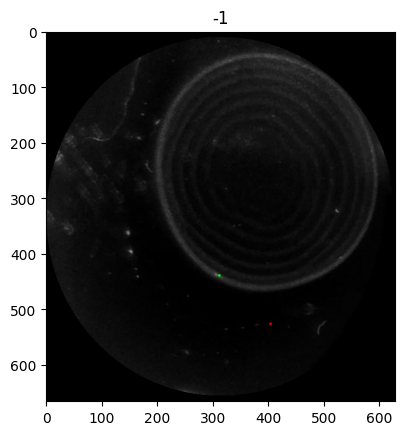

[206 201] [440 265]


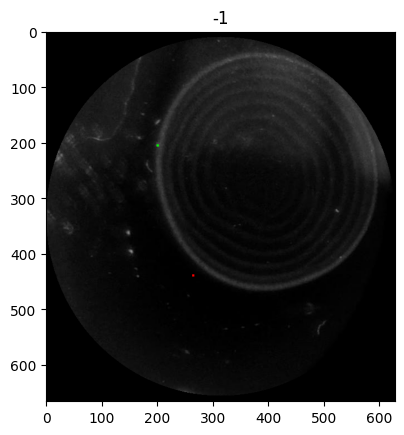

[388 249] [666 508]


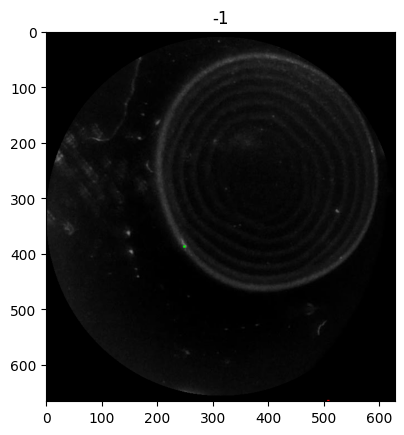

[138 413] [544 527]


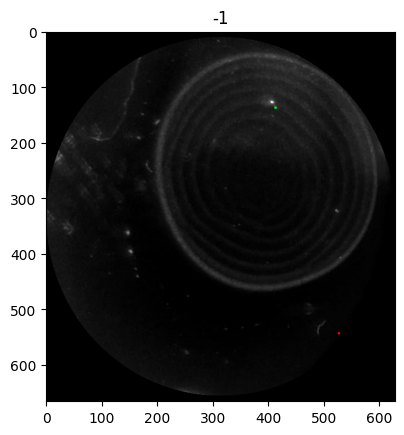

[377 245] [715 515]


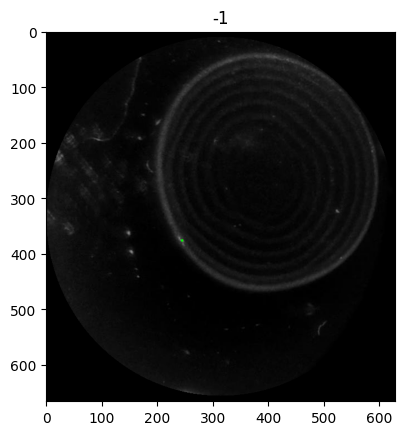

[153 214] [410 315]


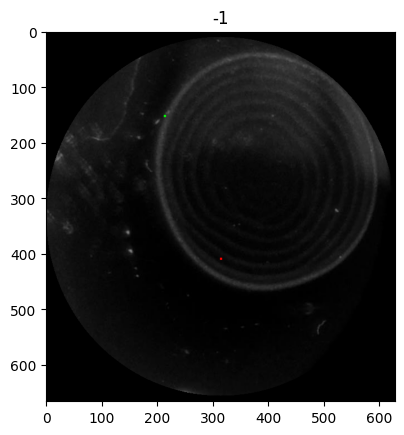

[273 204] [458 356]


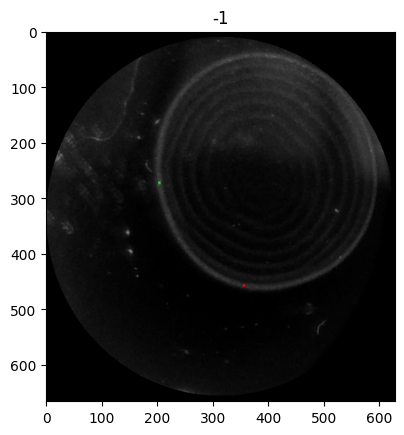

[212 223] [400 284]


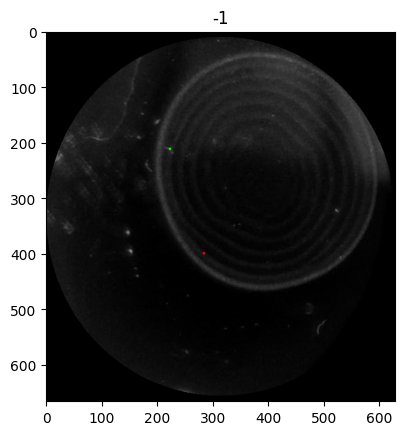

[350 230] [689 524]


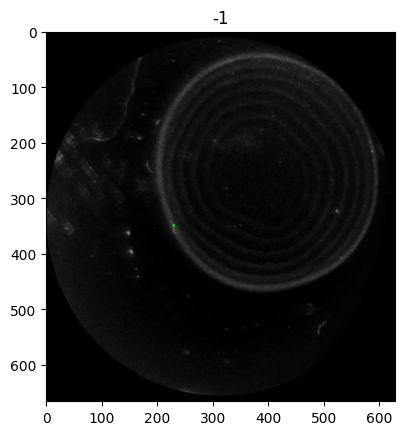

In [20]:
model.eval()
with torch.no_grad():
    for inputs, labels in it.islice(val_loader, 10):
        inputs = inputs.to(device)
        labels = labels.to(device)

        pred = model(inputs)

        for i in range(inputs.size()[0]):
            frame = np.transpose(inputs[i].cpu().numpy().astype(np.uint8), axes=(1, 2, 0))
            true_pos = larr2i(labels[i].cpu().numpy() * capture_size(cap2, dtype=np.float32))
            pred_pos = larr2i(pred[i].cpu().numpy() * capture_size(cap2, dtype=np.float32))
            print(true_pos, pred_pos)
            print_frame(False)(-1, frame, (true_pos, pred_pos))

### Tests

In [ ]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

#### Faster-RCNN

In [13]:
# Step 1: Initialize model with the best available weights
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [15]:
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()
# Step 3: Apply inference preprocessing transforms
batch = [preprocess(i3)]
# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(i3, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im.show()

/home/gbm/miniconda3/envs/ML-DL/lib/python3.10/site-packages/torchvision/utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


### Old

##### Main

In [6]:
cap.apply(remove_outside_petri((cap.W() // 2, cap.H() //2), int(cap.W()*0.9) // 2, (int(cap.H()*0.9) // 2)))
cap.apply(lambda i, f: (select_channel(0)(i, f) / 255.0).astype(np.float32), shape=(cap.W(), cap.H(), 1))

labels = {k: (v[0] / float(cap.W()), v[1] / float(cap.H()))  for k, v in labels.items()}

In [7]:
print("Info: ", cap.length(), cap.W(), cap.H(), cap.C())
print("Labels: ", len(labels))

Info:  12754 648 686 1
Labels:  12690


In [14]:
full_loss_history = []
loss_history = []
for epoch in range(1, EPOCHS + 1):
    model.train() 

    loss_history = []
    batch_idx = 1
    for data, label in loader:
        data, label = data.to(device), label.to(device)

        pred = model(data)
        loss = crit(pred, label)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_history.append(loss.item())

        if batch_idx % 1000 == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx} batch_loss={loss.item():0.2e}"
            )
        batch_idx = batch_idx + 1

    full_loss_history.extend(loss_history)

/home/gbm/miniconda3/envs/ML-DL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 1-1000 batch_loss=3.69e-03
Train Epoch: 1-2000 batch_loss=5.69e-03
Train Epoch: 1-3000 batch_loss=1.43e-02
Train Epoch: 1-4000 batch_loss=6.67e-03
Train Epoch: 1-5000 batch_loss=3.09e-04
Train Epoch: 1-6000 batch_loss=6.91e-05
Train Epoch: 1-7000 batch_loss=2.49e-04
Train Epoch: 1-8000 batch_loss=1.42e-03
Train Epoch: 1-9000 batch_loss=1.24e-03
Train Epoch: 1-10000 batch_loss=4.34e-05
Train Epoch: 1-11000 batch_loss=7.60e-03
Train Epoch: 1-12000 batch_loss=5.43e-04


Text(0, 0.5, 'Loss')

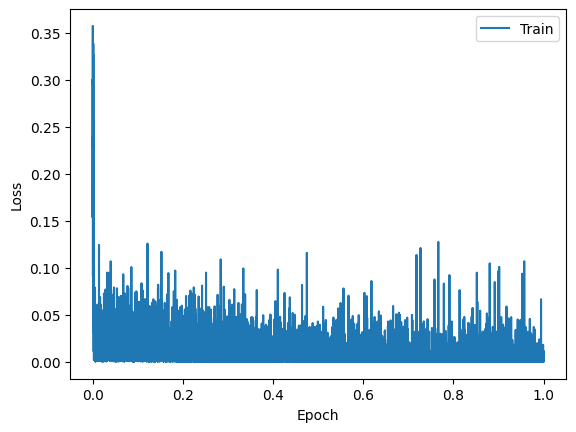

In [15]:
# ===== Plot training curves =====
n_train = len(full_loss_history)
t_train = EPOCHS * np.arange(n_train) / n_train
t_val = np.arange(1, EPOCHS + 1)
plt.figure()
plt.plot(t_train, full_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

##### Eval

In [16]:
from src.debug import print_frame

In [17]:
cap_e = LazyCapture.load('../data/pw1_A1_0315_part2.avi')
labels_e = load_labels('../data/pw1_A1_0315_part2.txt')

cap_e.apply(remove_outside_petri((cap.W() // 2, cap.H() //2), int(cap.W()*0.9) // 2, (int(cap.H()*0.9) // 2)))
cap_e.apply(lambda i, f: (select_channel(0)(i, f) / 255.0).astype(np.float32), shape=(cap.W(), cap.H(), 1))

labels_e = {k: (v[0] / float(cap.W()), v[1] / float(cap.H()))  for k, v in labels_e.items()}

In [18]:
loader_e = torch.utils.data.DataLoader(FramesDataset(cap_e, labels_e), batch_size=1)

In [ ]:
with torch.no_grad():
    for data, label in it.islice(loader_e, 10):
        data, label = data.to(device), label.to(device)
        pred = model(data)

        frame = np.transpose((data[0].cpu().numpy() * 255.0).astype(np.uint8), axes=(1, 2, 0))
        true_pos = (label[0].cpu().numpy() * np.array([cap.W(), cap.H()])).astype(np.int32)
        pred_pos = (pred.cpu().numpy() * np.array([cap.W(), cap.H()])).astype(np.int32)
        print_frame(True)(0, frame, (true_pos, pred_pos))
        